## In-Context Learning (ICL) fine-tuned with contextual information

In this section, we will fine-tune the In-Context Learning (ICL) model using additional contextual information. By incorporating general knowledge about geopolymer concrete, we aim to enhance the model's predictive capabilities and achieve better performance than the traditional models. The fine-tuning prompt considers the following factors for geopolymer concrete with FA/GGBFS:

1. Higher GGBFS content (e.g., 0.3/0.7) typically yields greater strength.
2. Lower W/C ratios generally result in increased compressive strength.
3. Enhanced powder content (FA + GGBFS) contributes to higher strength.
4. Curing methods: Heat curing is often more effective for higher FA content (e.g., 0.5/0.5), while GGBFS-rich blends can achieve adequate strength with ambient curing.



The fine-tuning process involves providing the model with concrete formulations as prompts and their respective compressive strength as completions for learning. Subsequently, the model will receive only prompts and will be required to generate completions itself. 

The prompt format is as follows:

Please consider the following disclaimer: For geopolymer concrete with FA/GGBFS, consider the following: (1) Higher GGBFS content (e.g., 0.3/0.7) typically yields greater strength. (2) Lower W/C ratios generally result in increased compressive strength. (3) Enhanced powder content (FA + GGBFS) contributes to higher strength. (4) Curing methods: Heat curing is often more effective for higher FA content (e.g., 0.5/0.5), while GGBFS-rich blends can achieve adequate strength with ambient curing.; We will do an exercise where I will provide you with concrete formulations as prompts and their respective respective compressive strength as completions for you to learn from. Then you will only receive prompts and need to complete it yourself. Add the respective Idx to each answer. Let's go:

{training_text}


All training and test sets used for the experiments will be stored in the `results` folder, allowing for easy access and reproducibility of the study.

In [54]:
# Predict Alkali activated concrete properties with in-context learning using openAI's text-davinci-003 model

import openai
import random
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import re

# Load API key
openai.api_key = "openai_key"

# Read data from file
with open("data\transformed_data.txt", "r") as f:
    data = f.readlines()

# Randomly sample n lines for training and N lines for testing
n = 10
N = 25

# Initialize empty lists to store results
result_list = []
predictions_list = []
true_values_list = []

# Repeat the process 10 times
for i in range(10):
    random.seed(i)
    random.shuffle(data)
    train_data = data[:n]
    test_data = data[n:n+N]
    training_prompts = [line.strip() for line in train_data]

    # Concatenate training prompts with completions
    training_text = "\n".join(training_prompts)

    # Initialize API call with training text disclaimer
    prompt = f"Please consider the following disclaimer: For geopolymer concrete with FA/GGBFS, consider the following: (1) Higher GGBFS content (e.g., 0.3/0.7) typically yields greater strength. (2) Lower W/C ratios generally result in increased compressive strength. (3) Enhanced powder content (FA + GGBFS) contributes to higher strength. (4) Curing methods: Heat curing is often more effective for higher FA content (e.g., 0.5/0.5), while GGBFS-rich blends can achieve adequate strength with ambient curing.; We will do an exercise where I will provide you with concrete formulations as prompts and their respective respective compressive strength as completions for you to learn from. Then you will only receive prompts and need to complete it yourself. Add the respective Idx to each answer. Lets go:\n\n{training_text}\n"
    
    def generate_prediction(test_prompt):
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=test_prompt + " What is the predicted compressive strength?",
            max_tokens=10,
            n=1,
            stop=None,
            temperature=0,
        )   
        result_text = response.choices[0].text.strip()
        print('result_text',result_text)
        result_text = re.sub("[^0-9.]", "", result_text)
        return float(result_text)
    

    # Filename where the strings will be saved
    file_name = 'results\ICL_finetuned\train.txt'
    
    # Open the file in append mode ('a') and write the strings one by one
    with open(file_name, 'a') as f:
        f.write(prompt)
    test_prompts = [line.split("; completion:")[0] for line in test_data]
    true_values = [float(line.split("; completion:")[1]) for line in test_data]
    predictions = [generate_prediction(prompt + test_prompt) for test_prompt in test_prompts]

    r2 = r2_score(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    # Evaluation 
    print(f"R-squared: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    # Scatter plot of predicted vs. true values
    plt.scatter(true_values, predictions, label='Predicted vs. Ground Truth')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')

    # Add a dashed diagonal line
    min_value = min(min(predictions), min(true_values))
    max_value = max(max(predictions), max(true_values))
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Diagonal Line')

    # Add legend and display the plot
    plt.legend()
    plt.show()

    # Save the results to a list
    result_dict = {'Test Prompt': test_prompts, 'True Value': true_values, 'Predicted Values': predictions}
    result_list.append(result_dict)
    predictions_list.append(predictions)
    true_values_list.append(true_values)

# Concatenate all the
# Scatter plot of predicted vs. true values
plt.scatter(true_values, predictions, label='Predicted vs. Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')

# Add a dashed diagonal line
min_value = min(min(predictions), min(true_values))
max_value = max(max(predictions), max(true_values))
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Diagonal Line')

# Add legend and display the plot
plt.legend()
plt.show()

# Save the results to a list
result_dict = {'Test Prompt': test_prompts, 'True Value': true_values, 'Predicted Values': predictions}
result_list.append(result_dict)
predictions_list.append(predictions)
true_values_list.append(true_values)
taining_dict = {''}
# Concatenate all the results to a single DataFrame
result_df = pd.concat([pd.DataFrame(result_dict) for result_dict in result_list], ignore_index=True)
# Save the results to a single CSV file
result_df.to_csv('results\ICL_finetuned\test.csv', index=False)

print(f"Results for {N*10} iterations are saved to a single CSV file.")


FileNotFoundError: [Errno 2] No such file or directory: 'data\transformed_data.txt'

### Vanilla In-Context Learning (ICL)

In this section, we will benchmark the performance of the In-Context Learning (ICL) model using the text-davinci-003 model from OpenAI. ICL leverages large language models to incorporate context and general knowledge, providing flexibility in handling non-numeric inputs and overcoming the limitations of traditional vector space formulations. The experiments will be conducted using the OpenAI API without any additional fine-tuning or contextual information.

All training and test sets used for the experiments will be stored in the `results` folder, allowing for easy access and reproducibility of the study.


In [ ]:
# Predict Alkali activated concrete properties with in-context learning using openAI's text-davinci-003 model

import openai
import random
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import re

# Load API key
openai.api_key = "openai_key"

# Read data from file
with open("data\transformed_data.txt", "r") as f:
    data = f.readlines()

# Randomly sample n lines for training and N lines for testing
n = 10
N = 25

# Initialize empty lists to store results
result_list = []
predictions_list = []
true_values_list = []

# Repeat the process 10 times
for i in range(10):
    random.seed(i)
    random.shuffle(data)
    train_data = data[:n]
    test_data = data[n:n+N]
    training_prompts = [line.strip() for line in train_data]

    # Concatenate training prompts with completions
    training_text = "\n".join(training_prompts)

    # Initialize API call with training text no disclaimer
    prompt = f" We will do an exercise where I will provide you with concrete formulations as prompts and their respective respective compressive strength as completions for you to learn from. Then you will only receive prompts and need to complete it yourself. Add the respective Idx to each answer. Lets go:\n\n{training_text}\n"
    #prompt = f"Please consider the following disclaimer: For geopolymer concrete with FA/GGBFS, consider the following: (1) Higher GGBFS content (e.g., 0.3/0.7) typically yields greater strength. (2) Lower W/C ratios generally result in increased compressive strength. (3) Enhanced powder content (FA + GGBFS) contributes to higher strength. (4) Curing methods: Heat curing is often more effective for higher FA content (e.g., 0.5/0.5), while GGBFS-rich blends can achieve adequate strength with ambient curing.; We will do an exercise where I will provide you with concrete formulations as prompts and their respective respective compressive strength as completions for you to learn from. Then you will only receive prompts and need to complete it yourself. Add the respective Idx to each answer. Lets go:\n\n{training_text}\n"
    
    def generate_prediction(test_prompt):
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=test_prompt + " What is the predicted compressive strength?",
            max_tokens=10,
            n=1,
            stop=None,
            temperature=0,
        )   
        result_text = response.choices[0].text.strip()
        print('result_text',result_text)
        result_text = re.sub("[^0-9.]", "", result_text)
        return float(result_text)
    

    # Filename where the strings will be saved
    file_name = 'results\ICL\train.txt'
    
    # Open the file in append mode ('a') and write the strings one by one
    with open(file_name, 'a') as f:
        f.write(prompt)
    test_prompts = [line.split("; completion:")[0] for line in test_data]
    true_values = [float(line.split("; completion:")[1]) for line in test_data]
    predictions = [generate_prediction(prompt + test_prompt) for test_prompt in test_prompts]

    r2 = r2_score(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    # Evaluation 
    print(f"R-squared: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    # Scatter plot of predicted vs. true values
    plt.scatter(true_values, predictions, label='Predicted vs. Ground Truth')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')

    # Add a dashed diagonal line
    min_value = min(min(predictions), min(true_values))
    max_value = max(max(predictions), max(true_values))
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Diagonal Line')

    # Add legend and display the plot
    plt.legend()
    plt.show()

    # Save the results to a list
    result_dict = {'Test Prompt': test_prompts, 'True Value': true_values, 'Predicted Values': predictions}
    result_list.append(result_dict)
    predictions_list.append(predictions)
    true_values_list.append(true_values)

# Concatenate all the
# Scatter plot of predicted vs. true values
plt.scatter(true_values, predictions, label='Predicted vs. Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Values')

# Add a dashed diagonal line
min_value = min(min(predictions), min(true_values))
max_value = max(max(predictions), max(true_values))
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Diagonal Line')

# Add legend and display the plot
plt.legend()
plt.show()

# Save the results to a list
result_dict = {'Test Prompt': test_prompts, 'True Value': true_values, 'Predicted Values': predictions}
result_list.append(result_dict)
predictions_list.append(predictions)
true_values_list.append(true_values)
taining_dict = {''}
# Concatenate all the results to a single DataFrame
result_df = pd.concat([pd.DataFrame(result_dict) for result_dict in result_list], ignore_index=True)
# Save the results to a single CSV file
result_df.to_csv('results\ICL\test.csv', index=False)

print(f"Results for {N*10} iterations are saved to a single CSV file.")


### Gaussian Process Regression (GPR)

In this section, we will benchmark the performance of the Gaussian Process Regression (GPR) model using the `scikit-learn` library. GPR is a non-parametric, Bayesian approach to regression that provides uncertainty estimates of the predictions. It is based on the assumption that any finite set of data points can be modeled by a multivariate Gaussian distribution.

All training and test sets used for the experiments will be stored in the `results` folder, allowing for easy access and reproducibility of the study.



Iteration: 1
R-squared: 0.76
MAE: 3.84
MSE: 33.45


<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


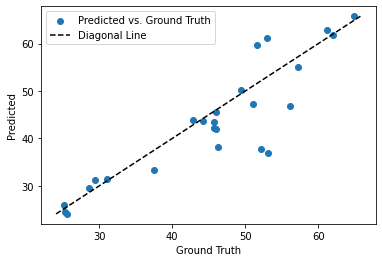

/Users/christophvoelker/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 2
R-squared: -2.66
MAE: 16.57
MSE: 370.60


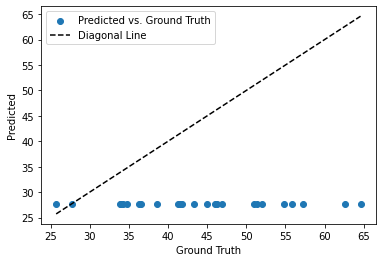

<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 3
R-squared: 0.67
MAE: 3.88
MSE: 24.64


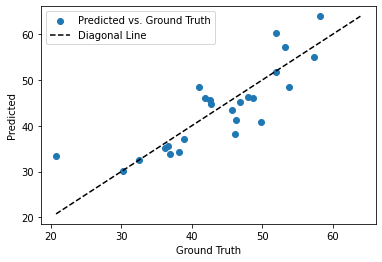

Iteration: 4
R-squared: -4.08
MAE: 19.54
MSE: 467.32


/Users/christophvoelker/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


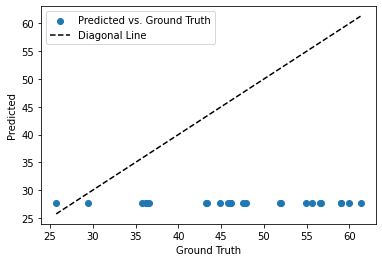

/Users/christophvoelker/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 5
R-squared: -3.51
MAE: 19.80
MSE: 502.54


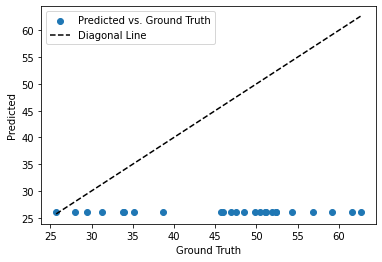

/Users/christophvoelker/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 6
R-squared: -2.47
MAE: 14.35
MSE: 311.22


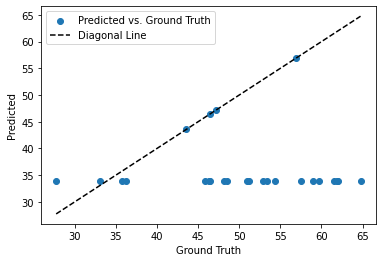

Iteration: 7
R-squared: 0.58
MAE: 5.60
MSE: 58.03


<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


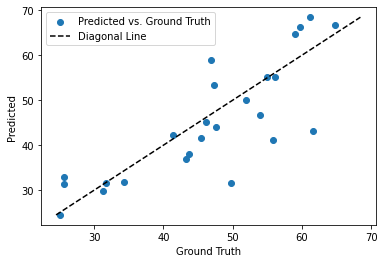

Iteration: 8
R-squared: 0.18
MAE: 6.72
MSE: 80.47


<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


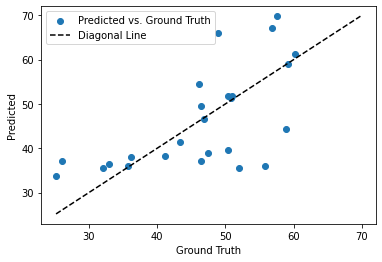

<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 9
R-squared: 0.83
MAE: 3.23
MSE: 19.25


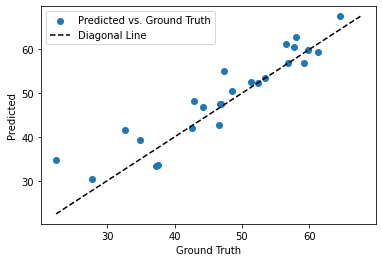

/Users/christophvoelker/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-53-7812d5d22d0a>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 10
R-squared: -0.63
MAE: 11.73
MSE: 211.41


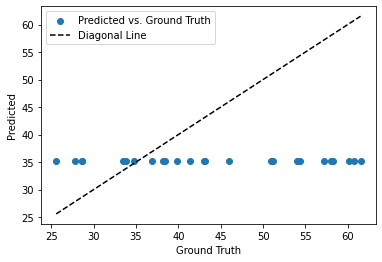

In [53]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import re
import matplotlib.pyplot as plt

data = pd.read_csv(r'data/numeric_data.csv')

# Function to extract indices from a given string
def extract_indices(s):
    indices = [int(x) for x in re.findall(r'Idx (\d+)', s)]
    return indices

# Read the train and test index files
with open('results/ICL/train.txt', 'r') as f:
    train_content = f.readlines()

with open('results/ICL/test.csv', 'r') as f:
    test_content = f.read()
    test_indices = extract_indices(test_content)
   
# Sample the test data based on the provided indices
test_data = data[data['Idx_Sample'].isin(test_indices)]

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel)

# DataFrames to store results
train_results_df = pd.DataFrame()
test_results_df = pd.DataFrame(columns=['Iteration', 'Idx_Sample', 'Input Features', 'True Values', 'Predicted Values'])


train_indices_all = []
for line in train_content:
    train_indices_all.extend(extract_indices(line))
num_train_samples = len(train_indices_all)
train_size_per_iteration = 10

test_indices_all = test_indices
num_test_samples = len(test_indices_all)
test_size_per_iteration = 25

for i in range(10):
    # Extract train indices for the current iteration
    train_indices = train_indices_all[i*train_size_per_iteration:(i+1)*train_size_per_iteration]
    
    # Extract test indices for the current iteration
    test_indices = test_indices_all[i*test_size_per_iteration:(i+1)*test_size_per_iteration]
    
    # Sample the data based on the provided indices
    train_data = data[data['Idx_Sample'].isin(train_indices)]
    test_data = data[data['Idx_Sample'].isin(test_indices)]

    target_column = 'fc_28dGroundTruth'
    idx_column = 'Idx_Sample'
    X_train = train_data.drop(columns=[target_column, idx_column], axis=1)

    # Normalize input features
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)

    # Scale the target variable for training
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(train_data[target_column].copy().to_numpy().reshape(-1, 1))

    gpr.fit(X_train, y_train)

    # Test data
    X_test = test_data.drop(columns=[target_column, idx_column], axis=1)
    X_test = X_scaler.transform(X_test)

    # Predict on test data
    predictions = gpr.predict(X_test)
    predictions = predictions.reshape(-1, 1)
    predictions = y_scaler.inverse_transform(predictions)

    # Store true and predicted values
    true_values = test_data[target_column].copy().to_numpy().reshape(-1, 1)
    idx_sample = test_data[idx_column].copy().to_numpy()

    # Store train data
    train_results_df = train_results_df.append(train_data)

    # Store test data
    iteration_df = pd.DataFrame({
        'Iteration': i+1,
        'Idx_Sample': idx_sample,
        'Input Features': list(X_test),
        'True Values': true_values.flatten(),
        'Predicted Values': predictions.flatten()
    })

    test_results_df = pd.concat([test_results_df, iteration_df], ignore_index=True)

    # Calculate R2 score and mean absolute error
    r2 = r2_score(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)   
    mse = mean_squared_error(true_values, predictions)

    # Evaluation
    print(f"Iteration: {i+1}")
    print(f"R-squared: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")

    # Scatter plot of predicted vs. true values
    plt.scatter(true_values, predictions, label='Predicted vs. Ground Truth')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')

    # Calculate min and max values
    min_value = min(min(predictions), min(true_values))
    max_value = max(max(predictions), max(true_values))

    # Create a list of x and y values for the diagonal line
    line_x = np.linspace(min_value, max_value, num=100)
    line_y = line_x

    # Plot the diagonal line
    plt.plot(line_x, line_y, 'k--', label='Diagonal Line')

    # Add legend and display the plot
    plt.legend()
    plt.show()

# Save the training and test data
train_results_df.to_csv(r'results/GPR/train.csv', index=False)
test_results_df.to_csv(r'results/GPR/test.csv', index=False)


### Random Forest (M5-Tree with Linear Tree Models)

In this section, we will benchmark the performance of the Random Forest (RF) model using an M5-Tree with linear tree models and well-calibrated uncertainty estimates, implemented in the `lolopy` library. RF is an ensemble learning method that constructs multiple decision trees and combines their output for improved prediction accuracy and reduced overfitting. The M5-Tree with linear tree models enhances the standard RF by incorporating linear regression models in the tree leaves, providing better performance on certain types of data.

All training and test sets used for the experiments will be stored in the `results` folder, allowing for easy access and reproducibility of the study.

Iteration: 1
R-squared: 0.77
MAE: 4.48
MSE: 31.75


<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


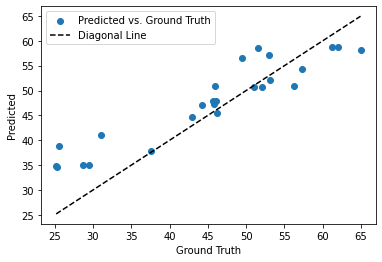

<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 2
R-squared: 0.79
MAE: 3.82
MSE: 21.44


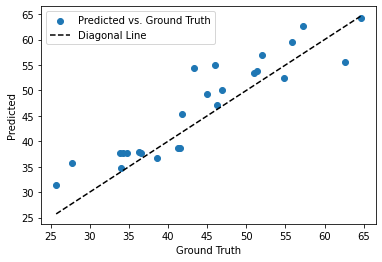

Iteration: 3
R-squared: 0.13
MAE: 6.62
MSE: 65.37


<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


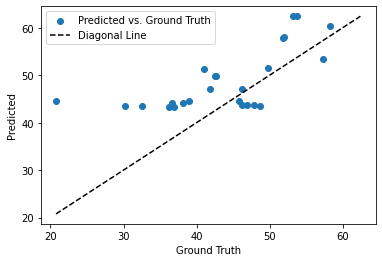

Iteration: 4
R-squared: 0.75
MAE: 4.18
MSE: 23.36


<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


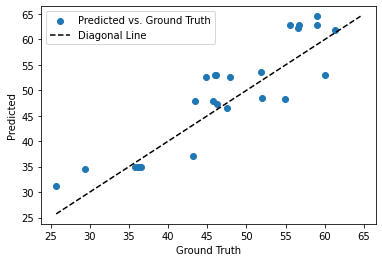

<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 5
R-squared: 0.77
MAE: 3.97
MSE: 26.03


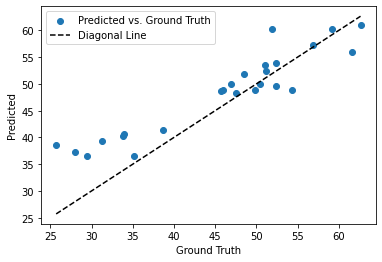

<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 6
R-squared: 0.42
MAE: 5.52
MSE: 52.42


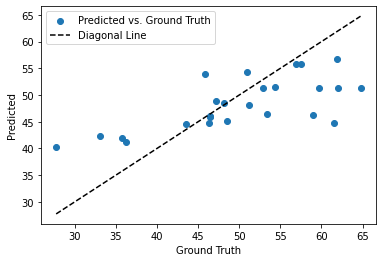

<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 7
R-squared: 0.70
MAE: 4.95
MSE: 41.77


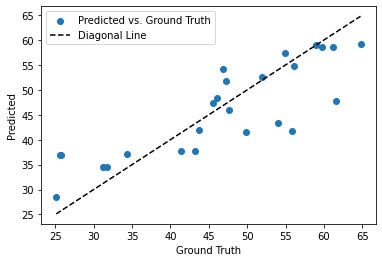

<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 8
R-squared: 0.54
MAE: 5.34
MSE: 44.94


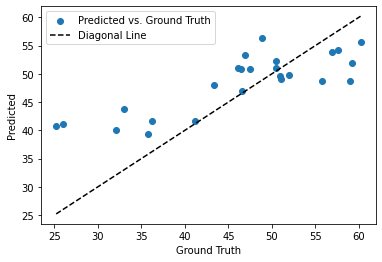

Iteration: 9
R-squared: 0.83
MAE: 3.52
MSE: 20.27


<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


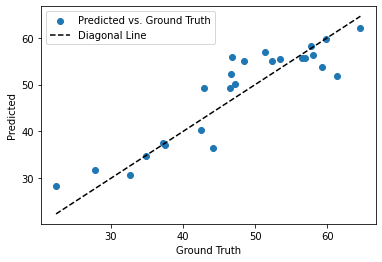

<ipython-input-52-8eef3c1acf3e>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_results_df = train_results_df.append(train_data)


Iteration: 10
R-squared: 0.68
MAE: 4.88
MSE: 41.51


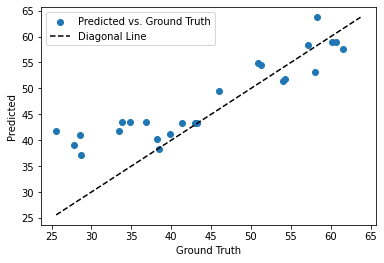

In [52]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lolopy.learners import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import re
import matplotlib.pyplot as plt

data = pd.read_csv(r'data/numeric_data.csv')

# Function to extract indices from a given string
def extract_indices(s):
    indices = [int(x) for x in re.findall(r'Idx (\d+)', s)]
    return indices

# Read the train and test index files
with open('results/ICL/train.txt', 'r') as f:
    train_content = f.readlines()

with open('results/ICL/test.csv', 'r') as f:
    test_content = f.read()
    test_indices = extract_indices(test_content)

#Sample the test data based on the provided indices
test_data = data[data['Idx_Sample'].isin(test_indices)]

# DataFrames to store results
train_results_df = pd.DataFrame()
test_results_df = pd.DataFrame(columns=['Iteration', 'Idx_Sample', 'Input Features', 'True Values', 'Predicted Values'])


train_indices_all = []
for line in train_content:
    train_indices_all.extend(extract_indices(line))
num_train_samples = len(train_indices_all)
train_size_per_iteration = 10

test_indices_all = test_indices
num_test_samples = len(test_indices_all)
test_size_per_iteration = 25

for i in range(10):
    # Extract train indices for the current iteration
    train_indices = train_indices_all[i*train_size_per_iteration:(i+1)*train_size_per_iteration]
    
    # Extract test indices for the current iteration
    test_indices = test_indices_all[i*test_size_per_iteration:(i+1)*test_size_per_iteration]
    
    # Sample the data based on the provided indices
    train_data = data[data['Idx_Sample'].isin(train_indices)]
    test_data = data[data['Idx_Sample'].isin(test_indices)]

    target_column = 'fc_28dGroundTruth'
    idx_column = 'Idx_Sample'
    X_train = train_data.drop(columns=[target_column, idx_column], axis=1)

    # Normalize input features
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)

    # Scale the target variable for training
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(train_data[target_column].copy().to_numpy().reshape(-1, 1))

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # Test data
    X_test = test_data.drop(columns=[target_column, idx_column], axis=1)
    X_test = X_scaler.transform(X_test)

    # Predict on test data
    predictions = rf.predict(X_test)
    predictions = predictions.reshape(-1, 1)
    predictions = y_scaler.inverse_transform(predictions)

    # Store true and predicted values
    true_values = test_data[target_column].copy().to_numpy().reshape(-1, 1)
    idx_sample = test_data[idx_column].copy().to_numpy()

    # Store train data
    train_results_df = train_results_df.append(train_data)

    # Store test data
    iteration_df = pd.DataFrame({
        'Iteration': i+1,
        'Idx_Sample': idx_sample,
        'Input Features': list(X_test),
        'True Values': true_values.flatten(),
        'Predicted Values': predictions.flatten()
    })

    test_results_df = pd.concat([test_results_df, iteration_df], ignore_index=True)

    # Calculate R2 score and mean absolute error
    r2 = r2_score(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)   
    mse = mean_squared_error(true_values, predictions)

    # Evaluation
    print(f"Iteration: {i+1}")
    print(f"R-squared: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")

    # Scatter plot of predicted vs. true values
    plt.scatter(true_values, predictions, label='Predicted vs. Ground Truth')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')

    # Calculate min and max values
    min_value = min(min(predictions), min(true_values))
    max_value = max(max(predictions), max(true_values))

    # Create a list of x and y values for the diagonal line
    line_x = np.linspace(min_value, max_value, num=100)
    line_y = line_x

    # Plot the diagonal line
    plt.plot(line_x, line_y, 'k--', label='Diagonal Line')

    # Add legend and display the plot
    plt.legend()
    plt.show()

# Save the training and test data
train_results_df.to_csv(r'results/RF/train.csv', index=False)
test_results_df.to_csv(r'results/RF/test.csv', index=False)
